In [2]:
import tools as tools
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Standard imports 
import numpy as np
import pandas as pd


# OS and time packages 
import os
import time
import tqdm

# Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

plt.rc('font', size=14)             # controls default text sizes
plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=14)       # legend fontsize
plt.rc('figure', titlesize=20)      # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

# Filter warnings 
pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

C:\Users\JBH\AppData\Local\Temp\ipykernel_8724\1862579915.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\JBH\AppData\Local\Temp\ipykernel_8724\1862579915.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by

Header (state non-commercial/academic intentions)

In [3]:
header = {'name' : 'Jørgen Baun Høst',          'email' : 'pjz633@econ.ku.dk',
          'intention': 'Scrape Boliga for academic purposes'}

In [19]:
df=pd.read_parquet('data/boliga.pq')
df['guid']=df['guid'].str.lower()
df

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,municipalityCode,estateCode,city,groupKey,canGetVR,bfEnr,year,month,week,time_q
0,0,Ørnhøjvej 7,9240,650000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2559.0552,8.0,254,...,851,626742,Nibe,NaN,True,8772902,2012,12,6,2012Q4
1,0,Sdr Lourupvej 14A,6690,250276,2012-12-30 23:00:00+00:00,1,Alm. Salg,1881.7744,4.0,133,...,561,308259,Gørding,NaN,True,5051843,2012,12,6,2012Q4
2,0,"Rådhusgade 17A, 1. tv",9670,1150000,2012-12-30 23:00:00+00:00,1,Alm. Salg,18253.9690,5.0,63,...,820,9422,Løgstør,NaN,True,5557002,2012,12,6,2012Q4
3,0,Hennetvedvej 15,5900,1600000,2012-12-30 23:00:00+00:00,1,Alm. Salg,5839.4160,11.0,274,...,482,4240,Rudkøbing,NaN,True,3075248,2012,12,6,2012Q4
4,782475,Halkærvej 15A,9240,750000,2012-12-30 23:00:00+00:00,1,Alm. Salg,7653.0610,3.0,98,...,851,626199,Nibe,NaN,True,3292315,2012,12,6,2012Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790439,0,Ny Vestergade 34A,5672,2295000,2006-11-28 23:00:00+00:00,1,Alm. Salg,39568.9650,2.0,58,...,430,1095,Broby,NaN,True,3063150,2006,11,1,2006Q4
790440,0,Vandværksvej 6,6990,1020000,2006-11-28 23:00:00+00:00,1,Alm. Salg,8500.0000,4.0,120,...,661,180229,Ulfborg,NaN,True,4504053,2006,11,1,2006Q4
790441,0,Utzonsgade 22,6000,1750000,2006-11-28 23:00:00+00:00,1,Alm. Salg,15765.7660,5.0,111,...,621,146327,Kolding,NaN,True,5680447,2006,11,1,2006Q4
790442,0,Harpelundevej 28,4900,350000,2006-11-28 23:00:00+00:00,1,Alm. Salg,2500.0000,3.0,140,...,360,17960,Nakskov,NaN,True,3103681,2006,11,1,2006Q4


In [20]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,estateCode,city,groupKey,canGetVR,bfEnr,year,month,week,time_q,geometry
0,0,Ørnhøjvej 7,9240,650000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2559.0552,8.0,254,...,626742,Nibe,NaN,True,8772902,2012,12,6,2012Q4,POINT (9.60154 56.91827)
1,0,Sdr Lourupvej 14A,6690,250276,2012-12-30 23:00:00+00:00,1,Alm. Salg,1881.7744,4.0,133,...,308259,Gørding,NaN,True,5051843,2012,12,6,2012Q4,POINT (8.80146 55.47826)
2,0,"Rådhusgade 17A, 1. tv",9670,1150000,2012-12-30 23:00:00+00:00,1,Alm. Salg,18253.9690,5.0,63,...,9422,Løgstør,NaN,True,5557002,2012,12,6,2012Q4,POINT (9.25550 56.96835)
3,0,Hennetvedvej 15,5900,1600000,2012-12-30 23:00:00+00:00,1,Alm. Salg,5839.4160,11.0,274,...,4240,Rudkøbing,NaN,True,3075248,2012,12,6,2012Q4,POINT (10.73517 54.85458)
4,782475,Halkærvej 15A,9240,750000,2012-12-30 23:00:00+00:00,1,Alm. Salg,7653.0610,3.0,98,...,626199,Nibe,NaN,True,3292315,2012,12,6,2012Q4,POINT (9.61028 56.95044)


In [21]:
kommune_2006 = gpd.read_file('data/kommune_2006.shp')
kommune_2006

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,24842.0,Københavns Kommune,120727.0,2002-12-31,2006-12-31,64.0,Kommune,154225.005507,9.028113e+07,"MULTIPOLYGON Z (((12.73424 55.70328 0.00000, 1..."
1,24843.0,Frederiksberg Kommune,120728.0,1970-04-01,2006-12-31,64.0,Kommune,13520.324243,8.709197e+06,"POLYGON Z ((12.53736 55.69661 0.00000, 12.5370..."
2,46149.0,Birkerød Kommune,120748.0,1974-01-04,2006-12-31,64.0,Kommune,35777.227097,3.366869e+07,"POLYGON Z ((12.45040 55.81888 0.00000, 12.4473..."
3,46165.0,Græsted-Gilleleje Kommune,120753.0,1972-10-01,2006-12-31,64.0,Kommune,67562.933801,1.341441e+08,"POLYGON Z ((12.39490 56.03226 0.00000, 12.3952..."
4,46190.0,Jægerspris Kommune,120759.0,1975-01-01,2006-12-31,64.0,Kommune,84485.880031,9.514108e+07,"MULTIPOLYGON Z (((11.92257 55.90000 0.00000, 1..."
...,...,...,...,...,...,...,...,...,...,...
266,46773.0,Thyborøn-Harboøre Kommune,120920.0,2002-12-31,2006-12-31,64.0,Kommune,95733.805758,3.953641e+07,"MULTIPOLYGON Z (((8.18948 56.59492 0.00000, 8...."
267,46789.0,Vinderup Kommune,120925.0,2002-12-31,2006-12-31,64.0,Kommune,109305.320681,2.175008e+08,"MULTIPOLYGON Z (((8.85937 56.39892 0.00000, 8...."
268,46793.0,Åskov Kommune,120926.0,2001-12-31,2006-12-31,64.0,Kommune,77105.236905,2.388402e+08,"POLYGON Z ((8.86526 55.89540 0.00000, 8.86505 ..."
269,46804.0,Galten Kommune,120928.0,2001-12-31,2006-12-31,64.0,Kommune,54492.128242,7.268604e+07,"POLYGON Z ((9.95809 56.13030 0.00000, 9.96044 ..."


In [22]:
regioner=gpd.read_file('data/regioner.shp')
regioner

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,105612.0,Region Hovedstaden,118711.0,2007-01-01,9999-12-31,66.0,Region,7.371152e+05,2.563160e+09,"MULTIPOLYGON Z (((15.19733 55.31846 0.00000, 1..."
1,105615.0,Region Sjælland,118712.0,2011-11-27,9999-12-31,66.0,Region,2.196684e+06,7.216493e+09,"MULTIPOLYGON Z (((12.54857 54.95316 0.00000, 1..."
2,105616.0,Region Syddanmark,118713.0,2007-01-01,9999-12-31,66.0,Region,2.436420e+06,1.209603e+10,"MULTIPOLYGON Z (((10.68129 54.72772 0.00000, 1..."
3,105620.0,Region Midtjylland,118715.0,2011-01-01,9999-12-31,66.0,Region,2.564054e+06,1.299856e+10,"MULTIPOLYGON Z (((11.67150 56.73861 0.00000, 1..."
4,105617.0,Region Nordjylland,118714.0,2007-01-01,9999-12-31,66.0,Region,1.697705e+06,7.870127e+09,"MULTIPOLYGON Z (((10.98412 57.21880 0.00000, 1..."


In [23]:
gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
cols_to_drop=['index_right',
 'objectid',
 'navn',
 'enhedid',
 'fra',
 'til',
 'enhedtype',
 'art',
 'SHAPE_Leng',
 'SHAPE_Area']
gdf_merge['kommune_old']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')
gdf_merge['region']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge

C:\Users\JBH\AppData\Local\Temp\ipykernel_8724\4171787026.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
C:\Users\JBH\AppData\Local\Temp\ipykernel_8724\4171787026.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,groupKey,canGetVR,bfEnr,year,month,week,time_q,geometry,kommune_old,region
0,0,Ørnhøjvej 7,9240,650000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2559.0552,8.0,254,...,NaN,True,8772902,2012,12,6,2012Q4,POINT (9.60154 56.91827),Nibe Kommune,Region Nordjylland
4,782475,Halkærvej 15A,9240,750000,2012-12-30 23:00:00+00:00,1,Alm. Salg,7653.0610,3.0,98,...,NaN,True,3292315,2012,12,6,2012Q4,POINT (9.61028 56.95044),Nibe Kommune,Region Nordjylland
12,485013,Kirkebjergevej 16,9240,530000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2760.4167,5.0,192,...,NaN,True,3292153,2012,12,6,2012Q4,POINT (9.60734 56.94492),Nibe Kommune,Region Nordjylland
637,798322,Anemonevej 1,9240,1350000,2012-12-17 23:00:00+00:00,1,Alm. Salg,10150.3760,5.0,133,...,NaN,True,5560301,2012,12,0,2012Q4,POINT (9.64762 56.98276),Nibe Kommune,Region Nordjylland
668,0,Halkærvej 54,9240,1925000,2012-12-17 23:00:00+00:00,1,Alm. Salg,21629.2130,4.0,89,...,NaN,True,8772879,2012,12,0,2012Q4,POINT (9.58058 56.92630),Nibe Kommune,Region Nordjylland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787897,0,Næblerødvej 14,4250,1450000,2006-12-20 23:00:00+00:00,1,Alm. Salg,11240.3110,5.0,129,...,NaN,True,2520858,2006,12,2,2006Q4,POINT (11.52272 55.34386),Fuglebjerg Kommune,Region Sjælland
789156,0,Kristiansholmsvej 11,4262,1350000,2006-12-11 23:00:00+00:00,1,Alm. Salg,12053.5710,3.0,112,...,NaN,True,2519685,2006,12,0,2006Q4,POINT (11.53148 55.21515),Fuglebjerg Kommune,Region Sjælland
789193,0,Krummerupvej 38,4250,1350000,2006-12-11 23:00:00+00:00,1,Alm. Salg,12053.5710,3.0,112,...,NaN,True,2528554,2006,12,0,2006Q4,POINT (11.51294 55.29964),Fuglebjerg Kommune,Region Sjælland
789940,0,Tystrupvej 3,4250,1805000,2006-12-04 23:00:00+00:00,1,Alm. Salg,18418.3670,4.0,98,...,NaN,True,2529222,2006,12,0,2006Q4,POINT (11.54201 55.37007),Fuglebjerg Kommune,Region Sjælland


In [24]:
house_price_index = pd.read_excel('data/house_price_index.xlsx')
house_price_index['time_q']=pd.PeriodIndex(house_price_index['time_q'], freq='Q')
house_price_index

,region,time_q,house_price_index
0,Region Hovedstaden,1996Q1,0.296
1,Region Hovedstaden,1996Q2,0.304
2,Region Hovedstaden,1996Q3,0.314
3,Region Hovedstaden,1996Q4,0.328
4,Region Hovedstaden,1997Q1,0.325
...,...,...,...
395,Region Nordjylland,2014Q4,1.009
396,Region Nordjylland,2015Q1,1.048
397,Region Nordjylland,2015Q2,1.059
398,Region Nordjylland,2015Q3,1.053


In [25]:
land_taxes = pd.read_excel('data/kmn_grundskyldspromille.xlsx', sheet_name='Sheet2')
land_taxes

,kommune_amt_2006,kommune_sund_2007,kommune_grundskyld2006,kommune_grundskyld2007,delta_tax,kommune_old
0,"32,10","32,00","34,00","34,00",0.00,Københavns Kommune
1,"31,20","31,20","27,00","27,00",0.00,Frederiksberg Kommune
2,"32,80","33,58","28,00","28,89",0.89,Ballerup-Måløv Kommune
3,"32,40","32,47","19,00","19,00",0.00,Brøndbyøster-Brøndbyvester Kommune
4,"32,60","32,81","25,70","25,70",0.00,Dragør Kommune
...,...,...,...,...,...,...
262,"32,60","33,13","22,00","24,14",2.14,Støvring Kommune
263,"33,10","32,66","24,00","26,22",2.22,Sæby Kommune
264,"33,00","32,70","22,00","24,82",2.82,Åbybro Kommune
265,"33,40","33,37","27,00","26,95",-0.05,Ålborg Kommune


In [26]:
property_evals_01=pd.read_parquet('data/bbr_eval2001.pq')
property_evals_01

,guid,eval_prop,eval_land,last_changed,eval_year
0,2fbd9776-15f5-40d3-bb95-32aba20b730b,2600000,703700,2022-03-28,2001
1,665bdc04-2e15-4e27-8367-c7fb4e8906af,2450000,760300,2022-01-14,2001
2,914d602b-e33c-467d-887c-99b036bb377e,800000,141400,2021-10-25,2001
3,8f4b2d05-140c-4d0e-ad52-7a9b2cc91aee,870000,145300,2021-09-08,2001
4,1e0fee11-4170-408b-bff9-43f0be8857df,870000,145300,2021-09-08,2001
...,...,...,...,...,...
508401,eae3b645-5390-4081-8f70-6f0b8fdceb5e,750000,155700,2001-01-01,2001
508402,0664c1b5-7028-48f1-a3c0-11cf876aeade,1150000,132600,2001-01-01,2001
508403,9d6fcad5-bd98-4871-bd64-d8e444fccbb7,213600,213600,2001-01-01,2001
508404,bc917a98-671f-4ea7-9532-09a91c42597e,1300000,195300,2001-01-01,2001


Merge landtaxes, house price index and bbr evaluations

In [27]:
df_merged = pd.DataFrame(gdf_merge)
df_merged_index = pd.merge(df_merged, house_price_index, left_on=['time_q', 'region'], right_on=['time_q', 'region'])
df_merged_index = pd.merge(df_merged_index, land_taxes, left_on=['kommune_old'], right_on=['kommune_old'])
df_merged_index = pd.merge(df_merged_index, property_evals_01, left_on=['guid'], right_on=['guid'])
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,house_price_index,kommune_amt_2006,kommune_sund_2007,kommune_grundskyld2006,kommune_grundskyld2007,delta_tax,eval_prop,eval_land,last_changed,eval_year
0,0,Ørnhøjvej 7,9240,650000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2559.0552,8.0,254,...,0.983,"33,40","33,37","21,00","26,95",5.95,990000,41400,2001-01-01,2001
1,0,Ørnhøjvej 7,9240,1325000,2005-09-20 22:00:00+00:00,1,Alm. Salg,5216.5356,8.0,254,...,0.872,"33,40","33,37","21,00","26,95",5.95,990000,41400,2001-01-01,2001
2,782475,Halkærvej 15A,9240,750000,2012-12-30 23:00:00+00:00,1,Alm. Salg,7653.0610,3.0,98,...,0.983,"33,40","33,37","21,00","26,95",5.95,420000,72700,2001-01-01,2001
3,0,Halkærvej 15A,9240,650000,2005-01-10 23:00:00+00:00,1,Alm. Salg,6632.6530,3.0,98,...,0.823,"33,40","33,37","21,00","26,95",5.95,420000,72700,2001-01-01,2001
4,485013,Kirkebjergevej 16,9240,530000,2012-12-30 23:00:00+00:00,1,Alm. Salg,2760.4167,5.0,192,...,0.983,"33,40","33,37","21,00","26,95",5.95,700000,85000,2001-01-01,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766440,71851,Rolighedsvej 11,4250,1405000,2007-03-29 22:00:00+00:00,1,Alm. Salg,10330.8830,4.0,136,...,1.051,"34,90","32,70","25,00","22,00",-3.00,820000,140100,2001-01-01,2001
766441,0,Lærkevej 27,4250,1100000,2007-03-09 23:00:00+00:00,1,Alm. Salg,7971.0146,5.0,138,...,1.051,"34,90","32,70","25,00","22,00",-3.00,830000,158200,2001-01-01,2001
766442,0,Møllegårdsvej 7,4262,345000,2007-02-18 23:00:00+00:00,1,Alm. Salg,6272.7270,1.0,55,...,1.051,"34,90","32,70","25,00","22,00",-3.00,280000,109300,2001-01-01,2001
766443,0,Sorøvej 5,4250,900000,2007-01-09 23:00:00+00:00,1,Alm. Salg,6293.7060,6.0,143,...,1.051,"34,90","32,70","25,00","22,00",-3.00,590000,47600,2001-01-01,2001


# Add variables: 
- real house prices (by house price index)
- real sqm price (by house price index)
- ln of property value (in 2001)

In [28]:
df_merged_index['real_price']=df_merged_index['price']/df_merged_index['house_price_index']
df_merged_index['real_sqmPrice']=df_merged_index['sqmPrice']/df_merged_index['house_price_index']
df_merged_index['ln_prop_value']=np.log(df_merged_index['eval_prop'])

c:\Users\JBH\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
def land_tax_change07(value):
    if value > 0:
        return "Higher"
    elif value < 0:
        return "Lower"
    else:
        return "Unchanged"
df_merged_index['tax_change_reform'] = df_merged_index.apply(lambda row: land_tax_change07(row['delta_tax']), axis = 1)
df_merged_index['tax_change_reform']=df_merged_index['tax_change_reform'].astype('category')

C:\Users\JBH\AppData\Local\Temp\ipykernel_8724\81071381.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()


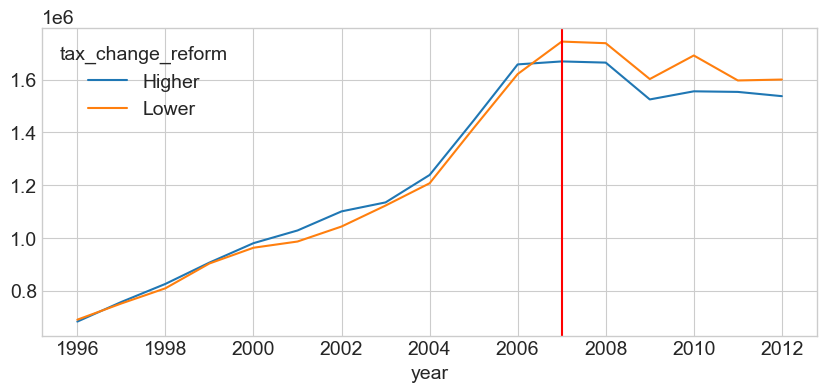

In [39]:
temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()
temp_agg_high_low = temp_agg.unstack()
plot=temp_agg_high_low['price'][['Higher', 'Lower']].plot()
plot.axvline(x=2007,color='r')